# In Depth: Support Vector Machines

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")
sns.set_style("whitegrid")
from scipy import stats

Consider instead discriminative classification. That is, rather than modeling each class, we will simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

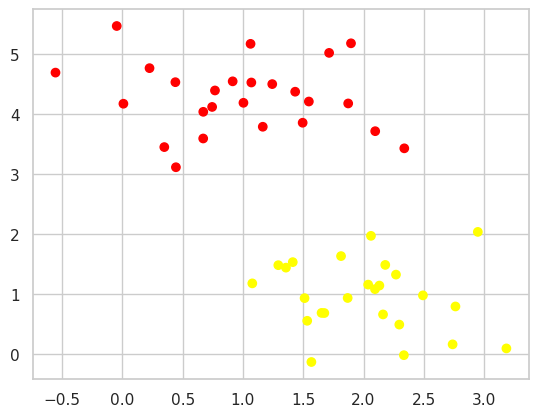

In [44]:
from sklearn.datasets import make_blobs
X, y = make_blobs(
    n_samples=50, centers=2,
    random_state=0, cluster_std=0.60
)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn');

/tmp/ipykernel_2794934/3095288780.py:7: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(-1, 3, 5);


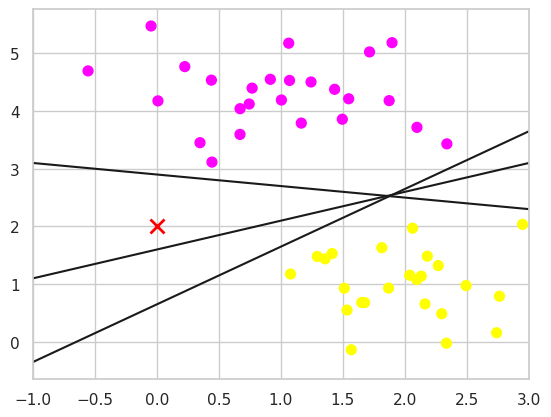

In [45]:
xfit = np.linspace(-1, 3, 5)
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='spring')
plt.plot([0,6], [2,1], 'x', 
         color='red', markeredgewidth=2, markersize=10)
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')
plt.xlim(-1, 3, 5);

Multiple lines can seperate the data.

## Maximizing the Margin

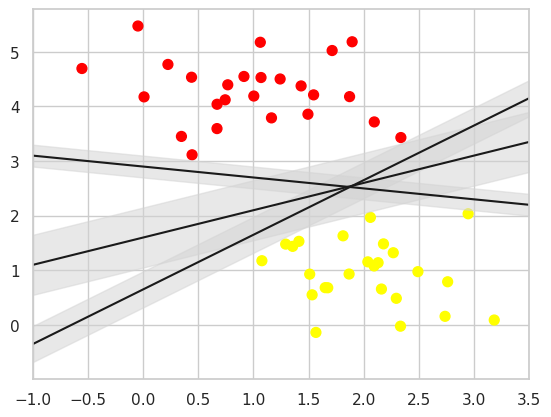

In [46]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='lightgray', alpha=0.5)

plt.xlim(-1, 3.5);

## Fitting a Support Vector Machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier (SVC) to train an SVM model on this data. For the time being, we will use a linear kernel and set the C parameter to a very large number (we'll discuss the meaning of these in more depth momentarily):

In [47]:
from sklearn.svm import SVC
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

In [48]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, edgecolors='black',
                   facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

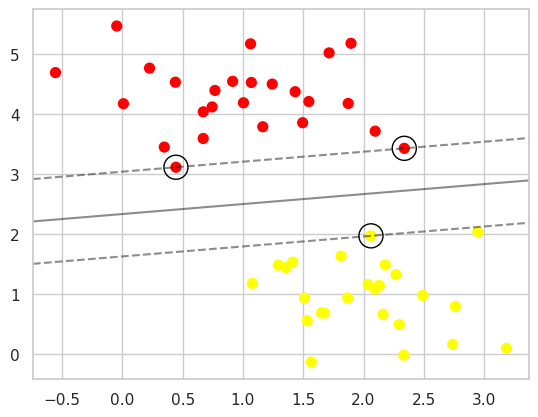

In [49]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

In [50]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the positions of the support vectors matter; any points further from the margin that are on the correct side do not modify the fit. Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

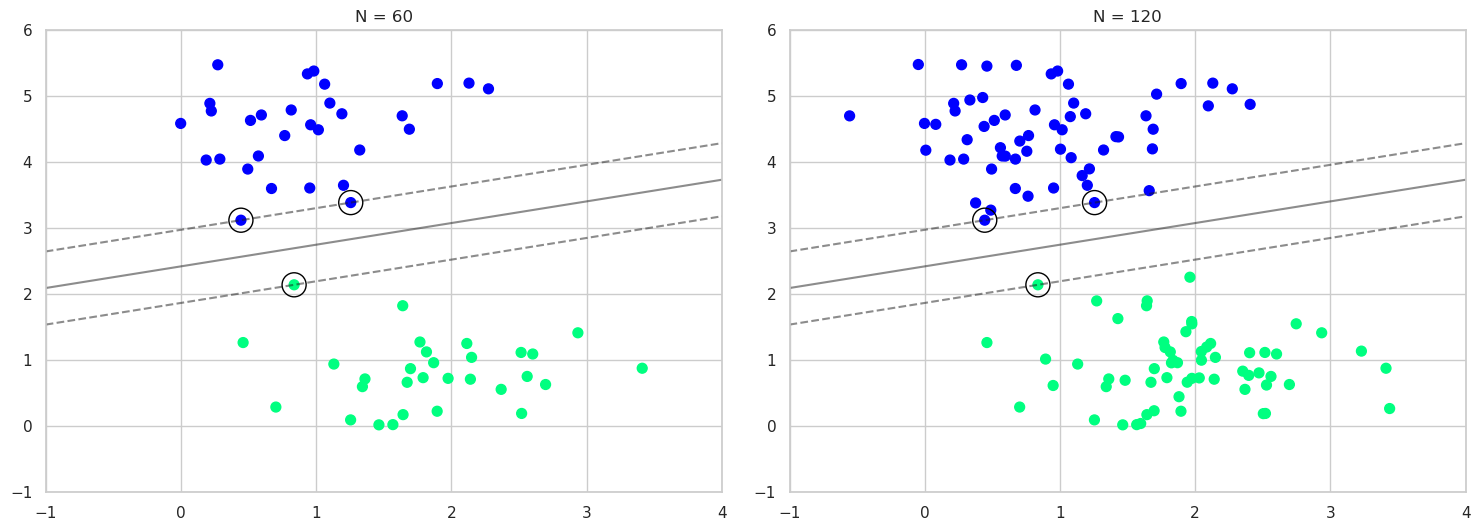

In [52]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2, 
                     random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10).fit(X, y)

    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16,6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

The insensitivity to N makes the model useful.

In [53]:
from ipywidgets import interact, fixed 
interact(plot_svm, N=(10, 200), ax=fixed(None));

interactive(children=(IntSlider(value=10, description='N', max=200, min=10), Output()), _dom_classes=('widget-…

### Beyond Linear Boundaries: Kernel SVM

Where SVM can become quite powerful is when it is combined with *kernels*.
We have seen a version of kernels before, in the basis function regressions of [In Depth: Linear Regression](05.06-Linear-Regression.ipynb).
There we projected our data into a higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.

In SVM models, we can use a version of the same idea.
To motivate the need for kernels, let's look at some data that is not linearly separable (see the following figure):

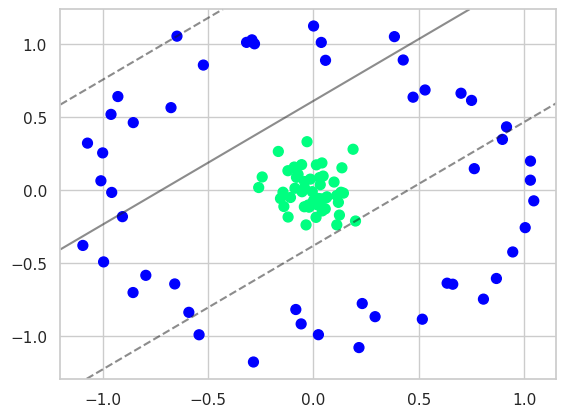

In [58]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='winter')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will ever be able to separate this data. But we can compute a radial basis function (RBF) centered on the middle clump

In [59]:
r = np.exp(-(X ** 2).sum(1))

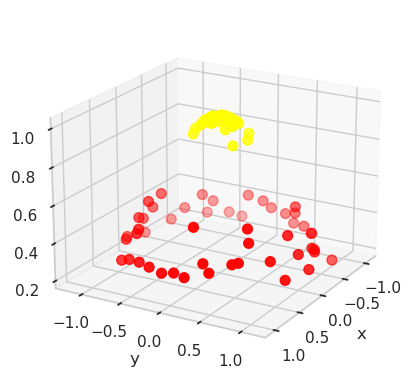

In [60]:
from mpl_toolkits import mplot3d

ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
ax.view_init(elev=20, azim=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r');

A potential problem with this strategy—projecting N points into N dimensions—is that it might become very computationally intensive as N grows large. However, because of a neat little procedure known as the kernel trick, a fit on kernel-transformed data can be done implicitly—that is, without ever building the full N-dimensional representation of the kernel projection. This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In [61]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X,y)

SVC(C=1000000.0)

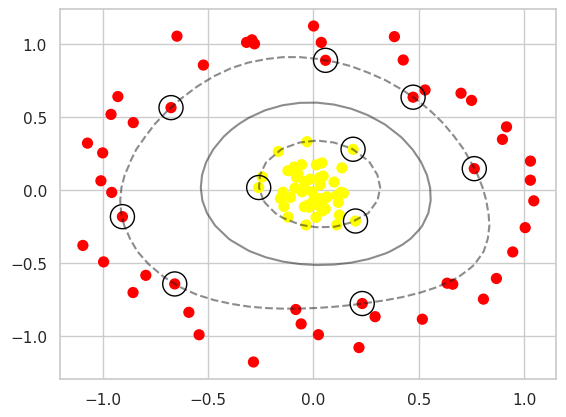

In [63]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

## Tuning the SVM: Softening Margins

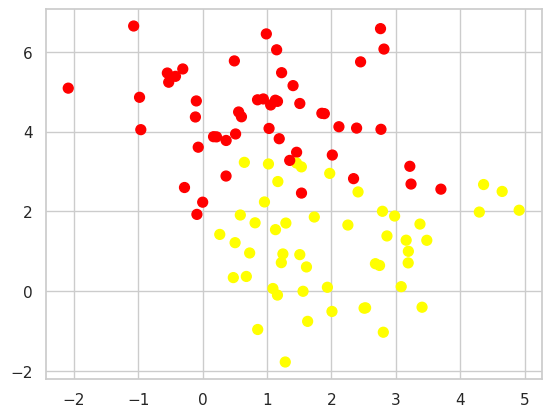

In [64]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation has a bit of a fudge factor that "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit. The hardness of the margin is controlled by a tuning parameter, most often known as C. For a very large C, the margin is hard, and points cannot lie in it. For a smaller C, the margin is softer and can grow to encompass some points.

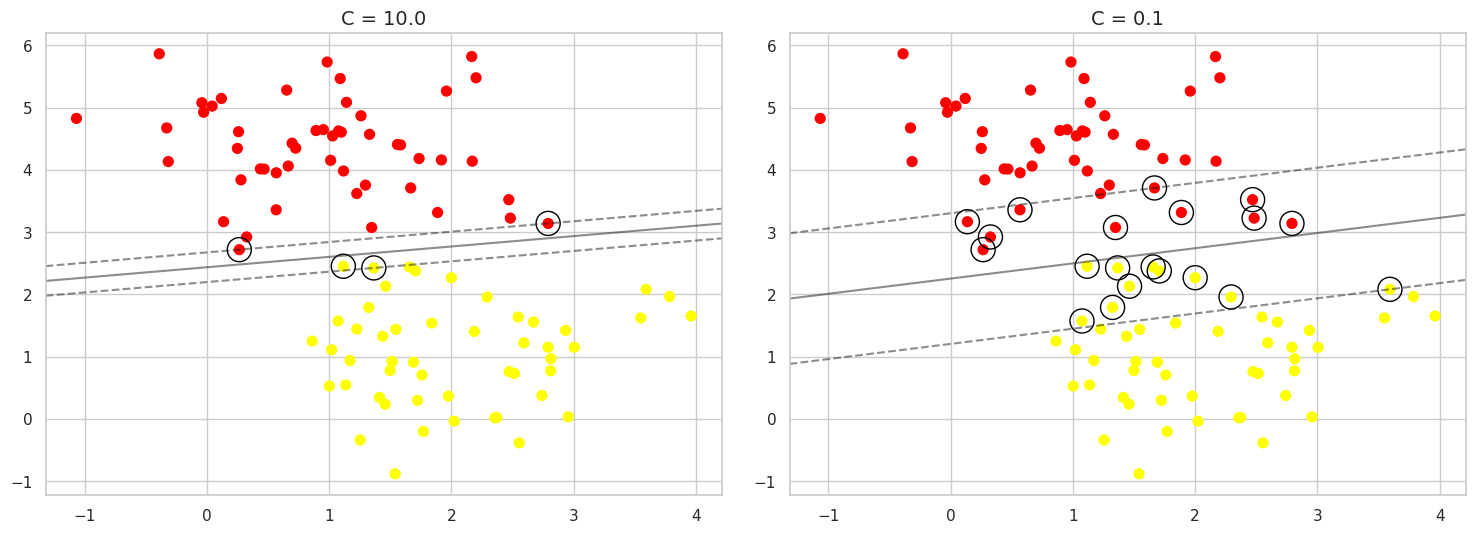

In [65]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:,0], 
               model.support_vectors_[:,1], 
               s=300, lw=1, facecolors='none')
    axi.set_title('C = {0:.1f}'.format(C), size=14);

## Example: Face Recognition

As an example of support vector machines in action, let's take a look at the facial recognition problem. We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures. A fetcher for the dataset is built into Scikit-Learn:

In [66]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


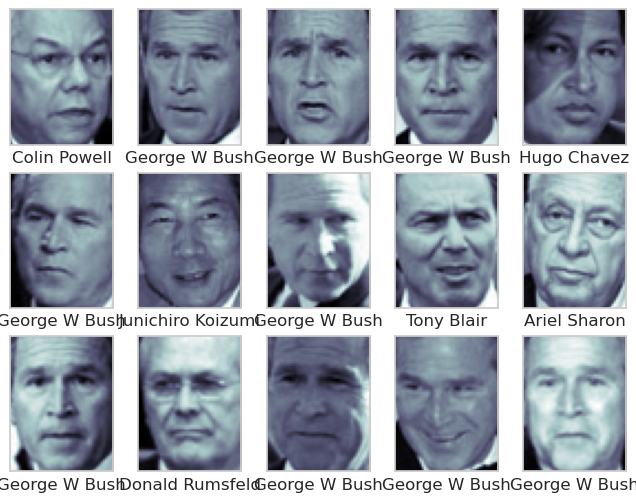

In [68]:
fig, ax = plt.subplots(3, 5, figsize=(8, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], 
           xlabel=faces.target_names[faces.target[i]])

In [69]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True,
          svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [70]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

In [74]:
from sklearn.model_selection import GridSearchCV
# param_grid = {'svc_C': [1, 5, 10, 50],
#              'svc_gamma': [0.0001, 0.0005, 0.001, 0.005]}
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 46.6 s, sys: 478 ms, total: 47.1 s
Wall time: 11.8 s
{'svc__C': 5, 'svc__gamma': 0.001}


In [75]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

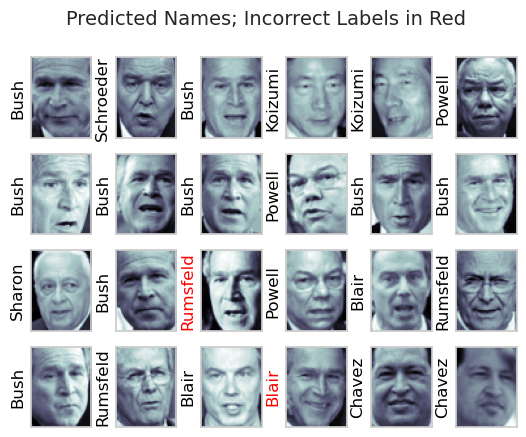

In [76]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [77]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



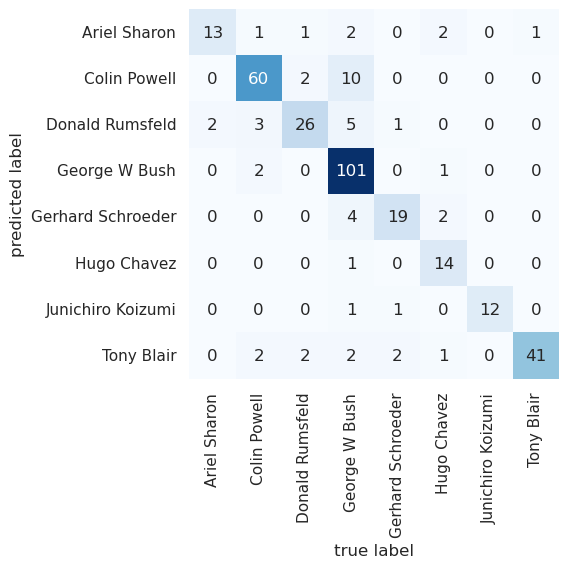

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
           cbar=False, cmap='Blues',
           xticklabels=faces.target_names, 
           yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Summary

This has been a brief intuitive introduction to the principles behind support vector machines.
These models are a powerful classification method, for a number of reasons:

- Their dependence on relatively few support vectors means that they are compact and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is challenging for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter `C`. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the `probability` parameter of `SVC`), but this extra estimation is costly.

With those traits in mind, I generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for my needs.
Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.